# Vision - Binary Image Classification

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of binary image classification with CNNs using the hot-dog/not-dog dataset on PyTorch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

from sklearn.metrics import classification_report, confusion_matrix

# Load Data

## Define Paths

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

root_dir = "../../../data/computer_vision/image_classification/hot-dog-not-hot-dog/"
print("The data lies here:", root_dir)

We're using: cuda
The data lies here: ../../../data/computer_vision/image_classification/hot-dog-not-hot-dog/


## Define transforms

Let's define a dictionary to hold the image transformations for train/test sets. 

In [3]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

## Initialize Datasets

### Train 

In [4]:
hotdog_dataset_train = datasets.ImageFolder(root = root_dir + "train",
                                            transform = image_transforms["train"]
                                           )

hotdog_dataset_train

Dataset ImageFolder
    Number of datapoints: 498
    Root location: ../../../data/computer_vision/image_classification/hot-dog-not-hot-dog/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### Test

In [5]:
hotdog_dataset_test = datasets.ImageFolder(root = root_dir + "test",
                                            transform = image_transforms["test"]
                                           )

hotdog_dataset_test

Dataset ImageFolder
    Number of datapoints: 500
    Root location: ../../../data/computer_vision/image_classification/hot-dog-not-hot-dog/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Output Classes

In [6]:
hotdog_dataset_train.classes

['hot_dog', 'not_hot_dog']

## Train and Test Dataloader

In [7]:
train_loader = DataLoader(dataset=hotdog_dataset_train, shuffle=True, batch_size=8)
test_loader = DataLoader(dataset=hotdog_dataset_test, shuffle=True, batch_size=1)

## Explore The Data

Let's look at a single image.

In [8]:
single_batch = next(iter(train_loader))

`single_batch` is a list of 2 elements. The first element (0th index) contains the image tensors while the second element (1st index) contains the output labels. 

Here's the first element of the list which is a tensor. This tensor is of the shape `(batch, channels, height, width)`. 

In [9]:
single_batch[0].shape

torch.Size([8, 3, 224, 224])

Here are the output labels for the batch.

In [10]:
print("Output label tensors: ", single_batch[1])
print("\nOutput label tensor shape: ", single_batch[1].shape)

Output label tensors:  tensor([1, 0, 0, 1, 0, 0, 0, 0])

Output label tensor shape:  torch.Size([8])


To plot the image, we'll use `plt.imshow` from matloptlib. It expects the image dimension to be `(height, width, channels)`. We'll `.permute()` our single image tensor to plot it. 

In [11]:
# Selecting the first image tensor from the batch. 
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


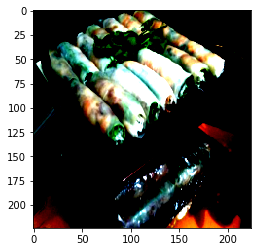

In [12]:
plt.imshow(single_image.permute(1, 2, 0))

PyTorch has made it easier for us to plot the images in a grid straight from the batch. 

We first extract out the image tensor from the list (returned by our dataloader) and set `nrow`. Then we use the `plt.imshow()` function to plot our grid. Remember to `.permute()` the tensor dimensions!

In [13]:
# We do single_batch[0] because each batch is a list 
# where the 0th index is the image tensor and 1st index is the output label.
single_batch_grid = utils.make_grid(single_batch[0], nrow=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


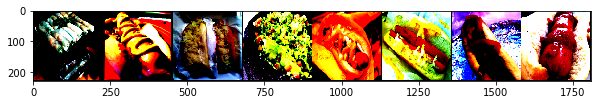

In [14]:
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## Define a CNN Architecture

In [15]:
class HotDogClassifier(nn.Module):
    def __init__(self):
        super(HotDogClassifier, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.cnn3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
        
        self.dropout = nn.Dropout2d(0.1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        
        self.fc = nn.Linear(256*224*224, 2)
        
        
    def forward(self, x):
        x = self.cnn1(x)
        x = self.batchnorm1(x)
        x = self.cnn2(x)
        x = self.dropout(x)
        x = self.batchnorm2(x)
        x = self.cnn3(x)
        x = self.batchnorm3(x)

        
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        
        return x

In [16]:
model = HotDogClassifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

HotDogClassifier(
  (cnn1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=12845056, out_features=2, bias=True)
)


In [17]:
model.train()
for e in range(20):
    epoch_loss = 0
    
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
    
        y_pred_probs = model(x_batch)
        
        loss = criterion(y_pred_probs, y_batch)
        
#         print(y_pred_probs.shape, y_batch.shape)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    
    print(f'Epoch {e+0:02}: | Loss: {epoch_loss/len(train_loader):.5f}')

Epoch 00: | Loss: 15071.62993
Epoch 01: | Loss: 8404.11070
Epoch 02: | Loss: 3385.29453
Epoch 03: | Loss: 1440.00452
Epoch 04: | Loss: 892.59197
Epoch 05: | Loss: 476.22294
Epoch 06: | Loss: 178.97320
Epoch 07: | Loss: 87.93931
Epoch 08: | Loss: 62.23099
Epoch 09: | Loss: 31.99046
Epoch 10: | Loss: 20.31334
Epoch 11: | Loss: 19.04873
Epoch 12: | Loss: 21.42762
Epoch 13: | Loss: 16.51995
Epoch 14: | Loss: 41.20778
Epoch 15: | Loss: 19.86935
Epoch 16: | Loss: 20.83524
Epoch 17: | Loss: 33.19066
Epoch 18: | Loss: 25.06542
Epoch 19: | Loss: 16.24920


In [19]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        y_pred_probs = model(x_batch)
        y_pred_probs_sigmoid = torch.sigmoid(y_pred_probs)        
        _, y_pred = torch.max(y_pred_probs_sigmoid, dim = 1)
        
        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [20]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.51      0.54      0.52       250
           1       0.51      0.49      0.50       250

    accuracy                           0.51       500
   macro avg       0.51      0.51      0.51       500
weighted avg       0.51      0.51      0.51       500

